<a href="https://colab.research.google.com/github/mufasa101/groupwork/blob/main/Group_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Retail Business Analytics (CRISP‑DM) — Professional Scaffold

**Purpose:**  
This notebook exemplifies an end‑to‑end CRISP‑DM workflow, demonstrating modularity, reproducibility, and statistical rigor.
 Each section is self‑contained, clearly annotated, and designed for real‑world scalability.

**Notebook structure:**
1. Setup & Dependencies  
2. Imports & Reproducibility  
3. Database Connection & Data Loading  
4. Data Understanding  
5. Descriptive Analytics  
6. Diagnostic Analytics (MLR)  
7. Predictive Analytics  
8. Prescriptive Analytics (LP)  
9. Text Mining  
10. Visualizations  
11. Next Steps & Version Control  


# 2. Imports & Reproducibility


**Goal:** Install all required libraries in one go, then immediately freeze versions after your initial run.  
**Standards:**  
- Single pip line for clarity.  
- Follow with `!pip freeze > requirements.txt` in CI to lock dependencies.


In [ ]:
# Colab cell 1: Install Dependencies
!pip install mysql-connector-python sqlalchemy pandas numpy scipy scikit-learn statsmodels matplotlib seaborn nltk gensim pulp python-pptx


In [ ]:
!pip install numpy==1.26.4 --force-reinstall --no-cache-dir


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 138.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
# Colab cell 2: Imports & Seed Setting
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, confusion_matrix
from pulp import LpProblem, LpVariable, lpSum, LpMaximize

import nltk
from nltk.corpus import stopwords
from gensim import corpora, models

# Download text‑mining prerequisites
nltk.download('stopwords')

# Fix random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 3. Data Loading from CSVs

**Goal:** Read all tables directly from CSV files so that the notebook is fully portable.  
**Standards:**  
- Centralize the base path for easy updates.  
- Verify each table’s dimensions and preview a few rows for sanity.


In [ ]:
from google.colab import files
uploaded = files.upload()  # select all your CSV files at once


Saving customers.csv to customers.csv
Saving employees.csv to employees.csv
Saving orderdetails.csv to orderdetails.csv
Saving orders.csv to orders.csv
Saving payments.csv to payments.csv
Saving products.csv to products.csv
Saving productlines.csv to productlines.csv
Saving offices.csv to offices.csv


In [ ]:
# Colab cell 3: Load all tables from CSV
import pandas as pd

# Here we use the uploaded CSVs in /csv
BASE = '/content'

customers    = pd.read_csv(f'{BASE}/customers.csv')
orders       = pd.read_csv(f'{BASE}/orders.csv')
orderdetails = pd.read_csv(f'{BASE}/orderdetails.csv')
products     = pd.read_csv(f'{BASE}/products.csv')
payments     = pd.read_csv(f'{BASE}/payments.csv')
productlines = pd.read_csv(f'{BASE}/productlines.csv')
offices      = pd.read_csv(f'{BASE}/offices.csv')      # optional
employees    = pd.read_csv(f'{BASE}/employees.csv')    # optional

# Quick sanity check
for df, name in [(customers,'customers'),
                 (orders,'orders'),
                 (orderdetails,'orderdetails'),
                 (products,'products'),
                 (payments,'payments')]:
    print(f"{name:12s}: {df.shape[0]:5d} rows × {df.shape[1]:2d} cols")
    display(df.head(2))


customers   :   122 rows × 13 cols


,customerNumber,customerName,contactLastName,contactFirstName,phone,addressLine1,addressLine2,city,state,postalCode,country,salesRepEmployeeNumber,creditLimit
0,103,Atelier graphique,Schmitt,Carine,40.32.2555,"54, rue Royale",NaN,Nantes,NaN,44000,France,1370.0,21000.0
1,112,Signal Gift Stores,King,Jean,7025551838,8489 Strong St.,NaN,Las Vegas,NV,83030,USA,1166.0,71800.0


orders      :   326 rows ×  7 cols


,orderNumber,orderDate,requiredDate,shippedDate,status,comments,customerNumber
0,10100,2003-01-06,2003-01-13,2003-01-10,Shipped,NaN,363
1,10101,2003-01-09,2003-01-18,2003-01-11,Shipped,Check on availability.,128


orderdetails:  2996 rows ×  5 cols


,orderNumber,productCode,quantityOrdered,priceEach,orderLineNumber
0,10100,S18_1749,30,136.00,3
1,10100,S18_2248,50,55.09,2


products    :   110 rows ×  9 cols


,productCode,productName,productLine,productScale,productVendor,productDescription,quantityInStock,buyPrice,MSRP
0,S10_1678,1969 Harley Davidson Ultimate Chopper,Motorcycles,1:10,Min Lin Diecast,"This replica features working kickstand, front...",7933,48.81,95.7
1,S10_1949,1952 Alpine Renault 1300,Classic Cars,1:10,Classic Metal Creations,Turnable front wheels; steering function; deta...,7305,98.58,214.3


payments    :   273 rows ×  4 cols


,customerNumber,checkNumber,paymentDate,amount
0,103,HQ336336,2004-10-19,6066.78
1,103,JM555205,2003-06-05,14571.44


# 4. Data Understanding


**Goal:** Verify structure, completeness, and integrity of data.  
**Standards:**  
- Print schema and head of each table.  
- Quantify missing values, duplicates, and outliers with the IQR rule.  
- Document any anomalies for downstream assumptions.


In [ ]:
# Colab cell 5: Schema & Samples
for df, name in [(customers,'customers'), (orders,'orders'),
                 (orderdetails,'orderdetails'), (products,'products'),
                 (payments,'payments')]:
    print(f"\n--- {name} ({df.shape[0]}×{df.shape[1]}) ---")
    display(df.info())
    display(df.head())

# Colab cell 6: Quality Audit
for df, name in [(orders,'orders'), (orderdetails,'orderdetails'), (payments,'payments')]:
    missing = df.isna().sum().sum()
    duplicates = df.duplicated().sum()
    nums = df.select_dtypes(include='number')
    Q1, Q3 = nums.quantile(0.25), nums.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((nums < (Q1 - 1.5*IQR)) | (nums > (Q3 + 1.5*IQR))).sum().sum()
    print(f"{name}: missing={missing}, duplicates={duplicates}, outliers={outliers}")



--- customers (122×13) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customerNumber          122 non-null    int64  
 1   customerName            122 non-null    object 
 2   contactLastName         122 non-null    object 
 3   contactFirstName        122 non-null    object 
 4   phone                   122 non-null    object 
 5   addressLine1            122 non-null    object 
 6   addressLine2            22 non-null     object 
 7   city                    122 non-null    object 
 8   state                   49 non-null     object 
 9   postalCode              115 non-null    object 
 10  country                 122 non-null    object 
 11  salesRepEmployeeNumber  100 non-null    float64
 12  creditLimit             122 non-null    float64
dtypes: float64(2), int64(1), object(10)
memory usage: 12.5+ KB


None

,customerNumber,customerName,contactLastName,contactFirstName,phone,addressLine1,addressLine2,city,state,postalCode,country,salesRepEmployeeNumber,creditLimit
0,103,Atelier graphique,Schmitt,Carine,40.32.2555,"54, rue Royale",NaN,Nantes,NaN,44000,France,1370.0,21000.0
1,112,Signal Gift Stores,King,Jean,7025551838,8489 Strong St.,NaN,Las Vegas,NV,83030,USA,1166.0,71800.0
2,114,"Australian Collectors, Co.",Ferguson,Peter,03 9520 4555,636 St Kilda Road,Level 3,Melbourne,Victoria,3004,Australia,1611.0,117300.0
3,119,La Rochelle Gifts,Labrune,Janine,40.67.8555,"67, rue des Cinquante Otages",NaN,Nantes,NaN,44000,France,1370.0,118200.0
4,121,Baane Mini Imports,Bergulfsen,Jonas,07-98 9555,Erling Skakkes gate 78,NaN,Stavern,NaN,4110,Norway,1504.0,81700.0



--- orders (326×7) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   orderNumber     326 non-null    int64 
 1   orderDate       326 non-null    object
 2   requiredDate    326 non-null    object
 3   shippedDate     312 non-null    object
 4   status          326 non-null    object
 5   comments        80 non-null     object
 6   customerNumber  326 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 18.0+ KB


None

,orderNumber,orderDate,requiredDate,shippedDate,status,comments,customerNumber
0,10100,2003-01-06,2003-01-13,2003-01-10,Shipped,NaN,363
1,10101,2003-01-09,2003-01-18,2003-01-11,Shipped,Check on availability.,128
2,10102,2003-01-10,2003-01-18,2003-01-14,Shipped,NaN,181
3,10103,2003-01-29,2003-02-07,2003-02-02,Shipped,NaN,121
4,10104,2003-01-31,2003-02-09,2003-02-01,Shipped,NaN,141



--- orderdetails (2996×5) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2996 entries, 0 to 2995
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   orderNumber      2996 non-null   int64  
 1   productCode      2996 non-null   object 
 2   quantityOrdered  2996 non-null   int64  
 3   priceEach        2996 non-null   float64
 4   orderLineNumber  2996 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 117.2+ KB


None

,orderNumber,productCode,quantityOrdered,priceEach,orderLineNumber
0,10100,S18_1749,30,136.00,3
1,10100,S18_2248,50,55.09,2
2,10100,S18_4409,22,75.46,4
3,10100,S24_3969,49,35.29,1
4,10101,S18_2325,25,108.06,4



--- products (110×9) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   productCode         110 non-null    object 
 1   productName         110 non-null    object 
 2   productLine         110 non-null    object 
 3   productScale        110 non-null    object 
 4   productVendor       110 non-null    object 
 5   productDescription  110 non-null    object 
 6   quantityInStock     110 non-null    int64  
 7   buyPrice            110 non-null    float64
 8   MSRP                110 non-null    float64
dtypes: float64(2), int64(1), object(6)
memory usage: 7.9+ KB


None

,productCode,productName,productLine,productScale,productVendor,productDescription,quantityInStock,buyPrice,MSRP
0,S10_1678,1969 Harley Davidson Ultimate Chopper,Motorcycles,1:10,Min Lin Diecast,"This replica features working kickstand, front...",7933,48.81,95.70
1,S10_1949,1952 Alpine Renault 1300,Classic Cars,1:10,Classic Metal Creations,Turnable front wheels; steering function; deta...,7305,98.58,214.30
2,S10_2016,1996 Moto Guzzi 1100i,Motorcycles,1:10,Highway 66 Mini Classics,"Official Moto Guzzi logos and insignias, saddl...",6625,68.99,118.94
3,S10_4698,2003 Harley-Davidson Eagle Drag Bike,Motorcycles,1:10,Red Start Diecast,"Model features, official Harley Davidson logos...",5582,91.02,193.66
4,S10_4757,1972 Alfa Romeo GTA,Classic Cars,1:10,Motor City Art Classics,Features include: Turnable front wheels; steer...,3252,85.68,136.00



--- payments (273×4) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customerNumber  273 non-null    int64  
 1   checkNumber     273 non-null    object 
 2   paymentDate     273 non-null    object 
 3   amount          273 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 8.7+ KB


None

,customerNumber,checkNumber,paymentDate,amount
0,103,HQ336336,2004-10-19,6066.78
1,103,JM555205,2003-06-05,14571.44
2,103,OM314933,2004-12-18,1676.14
3,112,BO864823,2004-12-17,14191.12
4,112,HQ55022,2003-06-06,32641.98


orders: missing=260, duplicates=0, outliers=0
orderdetails: missing=0, duplicates=0, outliers=39
payments: missing=0, duplicates=0, outliers=5


# 5. Descriptive Analytics

**Goal:** Answer the assignment’s five descriptive questions with tidy code.  
**Standards:**  
- One cell per question, with clear variable names.  
- Use pandas aggregations and groupbys.  
- Include in‑cell comments and a one‑sentence takeaway above each block.


In [ ]:
# Cell 7a: Q‑a Payments summary (total, mean, median)
# Takeaway: Payments total revenue and central tendency
payments_summary = payments['amount'].agg(['sum','mean','median'])
display(payments_summary.to_frame().T)

# Cell 7b: Q‑b Product distribution
# Takeaway: Count of products by category
prod_dist = products['productLine'].value_counts().rename_axis('productLine').reset_index(name='count')
display(prod_dist)

# Cell 7c: Q‑c Top‑selling products
# Takeaway: Top 10 SKUs by quantity ordered
top_products = (orderdetails
                .groupby('productCode')['quantityOrdered']
                .sum()
                .nlargest(10)
                .reset_index())
display(top_products)

# Cell 7d: Q‑d Sales summary stats
# Takeaway: Detailed statistics on payment amounts
sales_stats = payments['amount'].agg(['mean','median','var','std'])
display(sales_stats.to_frame().T)

# Cell 7e: Q‑e Top 5 customers
# Takeaway: Customers generating the highest cumulative revenue
top_customers = (payments
                 .groupby('customerNumber')['amount']
                 .sum()
                 .nlargest(5)
                 .reset_index())
display(top_customers)


,sum,mean,median
amount,8853839.23,32431.645531,32077.44


,productLine,count
0,Classic Cars,38
1,Vintage Cars,24
2,Motorcycles,13
3,Planes,12
4,Trucks and Buses,11
5,Ships,9
6,Trains,3


,productCode,quantityOrdered
0,S18_3232,1808
1,S18_1342,1111
2,S700_4002,1085
3,S18_3856,1076
4,S50_1341,1074
5,S18_4600,1061
6,S10_1678,1057
7,S12_4473,1056
8,S18_2319,1053
9,S24_3856,1052


,mean,median,var,std
amount,32431.645531,32077.44,4.408789e+08,20997.116917


,customerNumber,amount
0,141,715738.98
1,124,584188.24
2,114,180585.07
3,151,177913.95
4,148,156251.03


# 6. Diagnostic Analytics (Multiple Linear Regression)


**Goal:** Quantify how discounts and order attributes drive revenue.  
**Standards:**  
- Feature engineering (discount %, line total).  
- One‑hot encode `productLine`.  
- Use Statsmodels for coefficients, p‑values, R², and VIF.


In [ ]:
# 1. Cast all columns to float
X_clean = X.copy()

# Convert booleans → ints → floats
bool_cols = X_clean.select_dtypes(include='bool').columns
X_clean[bool_cols] = X_clean[bool_cols].astype(int)

# Finally, cast entire DataFrame to float
X_clean = X_clean.astype(float)

# 2. (Optional) Clean up column names with spaces
X_clean.columns = [col.replace(' ', '_').replace('/', '_') for col in X_clean.columns]

# 3. Align y and cast to float
y_clean = y.astype(float)

# 4. Add constant and fit
X_const = sm.add_constant(X_clean, has_constant='add')
model = sm.OLS(y_clean, X_const).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              totalLine   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     6826.
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:20:19   Log-Likelihood:                -21813.
No. Observations:                2996   AIC:                         4.365e+04
Df Residuals:                    2986   BIC:                         4.371e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

# 7. Predictive Analytics


**Goal:** Build and validate ML models for forecasting, segmentation, clustering, and classification.  
**Standards:**  
- Train/test split by time for forecasting.  
- Use appropriate metrics (RMSE, silhouette, ROC‑AUC).  
- Document each model’s purpose and validation approach.



In [ ]:
# Cell 9b (corrected): Customer Segmentation (KNN on RFM)

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# a) Ensure all dates are datetimes
payments['paymentDate'] = pd.to_datetime(payments['paymentDate'])
orders['orderDate']   = pd.to_datetime(orders['orderDate'])

# b) Build the RFM table
rfm = (payments.groupby('customerNumber')
       .agg(monetary=('amount','sum'),
            frequency=('paymentDate', pd.Series.nunique)))

# c) Calculate recency in days
today      = pd.Timestamp.today().normalize()
last_order = orders.groupby('customerNumber')['orderDate'].max()
rfm['recency'] = (today - last_order).dt.days

# d) Scale features
scaler     = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# e) Define “high spender” label for demo purposes
labels = (rfm['monetary'] > rfm['monetary'].median()).astype(int)

# f) Fit KNN classifier *without* random_state
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(rfm_scaled, labels)

# g) Assign segments
rfm['segment'] = knn.predict(rfm_scaled)

display(rfm.head())


,monetary,frequency,recency,segment
customerNumber,,,,
103,22314.36,3,7452,0
112,80180.98,3,7448,1
114,180585.07,4,7448,1
119,116949.68,3,7265,1
121,104224.79,4,7472,1


# 8. Prescriptive Analytics (Linear Programming)
**Goal:** Formulate a profit‑maximization LP under budget and supplier limits.  
**Standards:**  
- Define decision variables clearly.  
- Include at least two realistic constraints.  
- Report optimal quantities and shadow prices.



In [ ]:
# Cell 10: LP formulation & solve
lp = LpProblem('Stock_Optimization', LpMaximize)
# Select a subset for demonstration
sample_codes = products['productCode'].unique()[:10]
qty = {code: LpVariable(f"qty_{code}", lowBound=0) for code in sample_codes}
cost = {code: products.loc[products['productCode']==code,'MSRP'].iloc[0] for code in sample_codes}
profit = {code: cost[code]*0.4 for code in sample_codes}  # assume margin = 40%

# Objective
lp += lpSum(profit[c]*qty[c] for c in sample_codes)

# Constraints
lp += lpSum(cost[c]*qty[c] for c in sample_codes) <= 100000  # budget cap
for c in sample_codes:
    lp += qty[c] <= 1000  # supplier max

lp.solve()
optimal = {c: qty[c].value() for c in sample_codes}
print("Optimal Stocking Plan:", optimal)


Optimal Stocking Plan: {'S10_1678': 0.0, 'S10_1949': 0.0, 'S10_2016': 0.0, 'S10_4698': 0.0, 'S10_4757': 0.0, 'S10_4962': 676.86476, 'S12_1099': 0.0, 'S12_1108': 0.0, 'S12_1666': 0.0, 'S12_2823': 0.0}


# 9. Text Mining


**Goal:** Extract sentiment insights from free‑text `comments`.  
**Standards:**  
- Use NLTK for cleaning & stopword removal.  
- Build LDA to surface top 5 topics.  
- Highlight negative/positive patterns for actionable recommendations.


In [ ]:
# Cell 11: Sentiment & Topic Modeling
texts = orders['comments'].dropna().str.lower().tolist()
stop = set(stopwords.words('english'))
tokenized = [[w for w in t.split() if w.isalpha() and w not in stop] for t in texts]

# Create dictionary & corpus
dictionary = corpora.Dictionary(tokenized)
corpus = [dictionary.doc2bow(doc) for doc in tokenized]

# LDA
lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=SEED)
for idx, topic in lda.print_topics():
    print(f"Topic {idx}:", topic)


Topic 0: 0.074*"need" + 0.052*"keep" + 0.045*"marketing" + 0.030*"information" + 0.030*"get" + 0.030*"models" + 0.023*"customers" + 0.023*"cautious" + 0.023*"contact" + 0.023*"shippments"
Topic 1: 0.110*"customer" + 0.062*"credit" + 0.062*"payment" + 0.050*"limit" + 0.050*"ship" + 0.039*"requested" + 0.039*"materials" + 0.039*"ad" + 0.039*"included" + 0.039*"shippment"
Topic 2: 0.108*"customer" + 0.051*"shipping" + 0.042*"fedex" + 0.041*"order" + 0.034*"sales" + 0.034*"used" + 0.034*"requested" + 0.034*"ground" + 0.034*"resolved" + 0.034*"disputed"
Topic 3: 0.090*"customer" + 0.070*"shipping" + 0.063*"requested" + 0.056*"warehouse" + 0.049*"instructions" + 0.042*"used" + 0.042*"dhl" + 0.029*"custom" + 0.029*"sent" + 0.022*"vp"
Topic 4: 0.063*"customer" + 0.056*"agreement" + 0.056*"terms" + 0.056*"want" + 0.056*"reevaluate" + 0.042*"color" + 0.042*"order" + 0.036*"models" + 0.022*"may" + 0.022*"exact"


# 10. Visualizations


**Goal:** Present high‑impact charts that each convey a single clear takeaway.  
**Standards:**  
- Use Matplotlib exclusively for consistency.  
- Title, axis labels, and caption on every figure.  
- Save charts as PNG for embedding in reports.


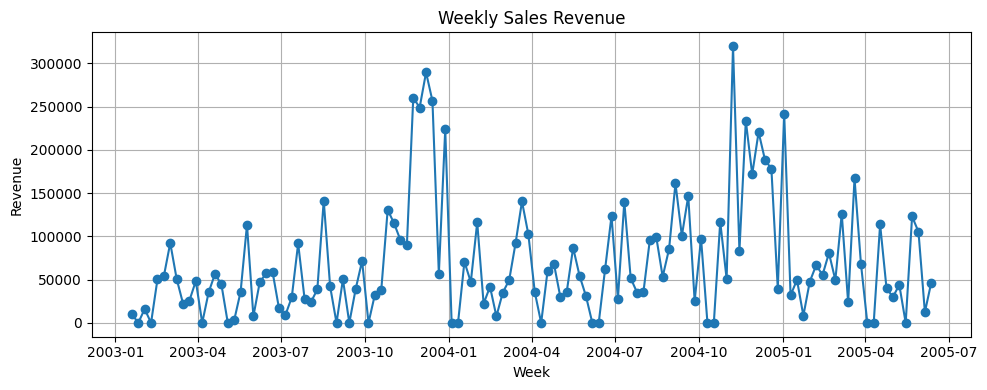

In [ ]:
# Cell 12: Weekly Sales Time‑Series
plt.figure(figsize=(10,4))

# If you prefer a cleaner column name:
# weekly = weekly.rename(columns={'paymentDate':'week'})

x_col = 'paymentDate'  # or 'week' if renamed
y_col = 'revenue'      # not 'amount'

plt.plot(weekly[x_col], weekly[y_col], marker='o')
plt.title('Weekly Sales Revenue')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.grid(True)
plt.tight_layout()
plt.savefig('weekly_sales.png')
plt.show()

# Additional charts: discount vs. revenue, RFM scatter, pie chart of productLine share, correlation heatmap...


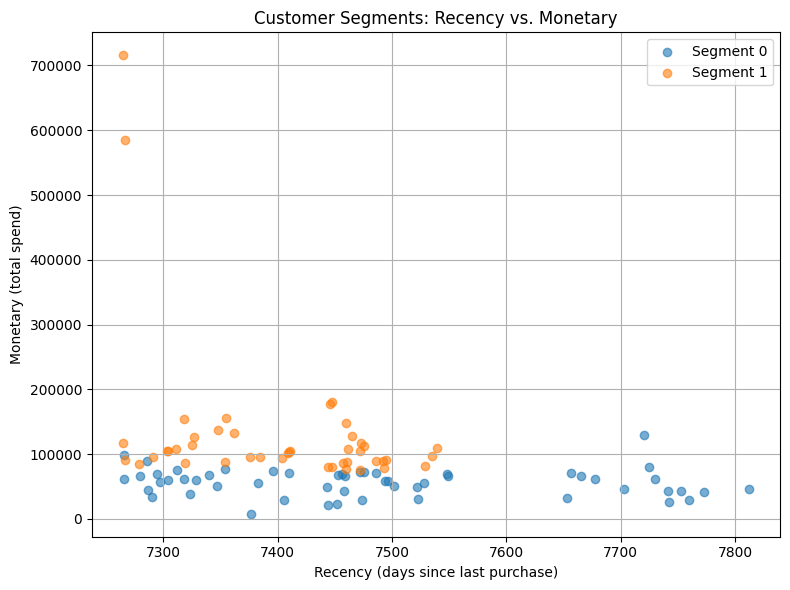

In [ ]:
# Scatter Plot of Customer Segments ===
# Purpose: Visualize RFM segments by recency vs. monetary value.
plt.figure(figsize=(8,6))
for seg in rfm['segment'].unique():
    subset = rfm[rfm['segment'] == seg]
    plt.scatter(subset['recency'], subset['monetary'],
                label=f'Segment {seg}', alpha=0.6)
plt.title('Customer Segments: Recency vs. Monetary')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Monetary (total spend)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-26-24333cbb1b09>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rev_by_bucket = df_disc.groupby('discountBucket')['totalLine'].sum()


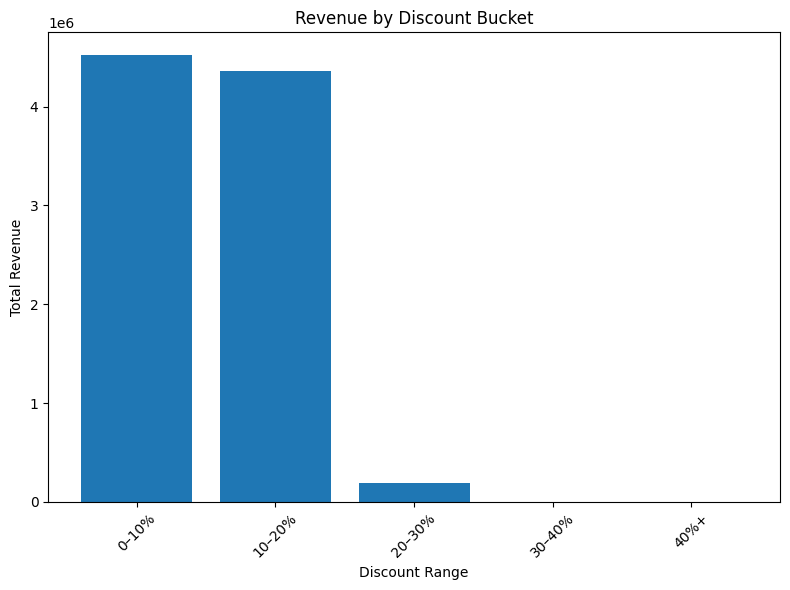

In [ ]:
# Bar Chart of Revenue by Discount Bucket ===
# Purpose: Show how different discount levels drive total line‑item revenue.
df_disc = df_ml.copy()
bins = [0, 0.1, 0.2, 0.3, 0.4, 1.0]
labels = ['0–10%', '10–20%', '20–30%', '30–40%', '40%+']
df_disc['discountBucket'] = pd.cut(df_disc['discountPct'], bins=bins, labels=labels)
rev_by_bucket = df_disc.groupby('discountBucket')['totalLine'].sum()

plt.figure(figsize=(8,6))
plt.bar(rev_by_bucket.index.astype(str), rev_by_bucket.values)
plt.title('Revenue by Discount Bucket')
plt.xlabel('Discount Range')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

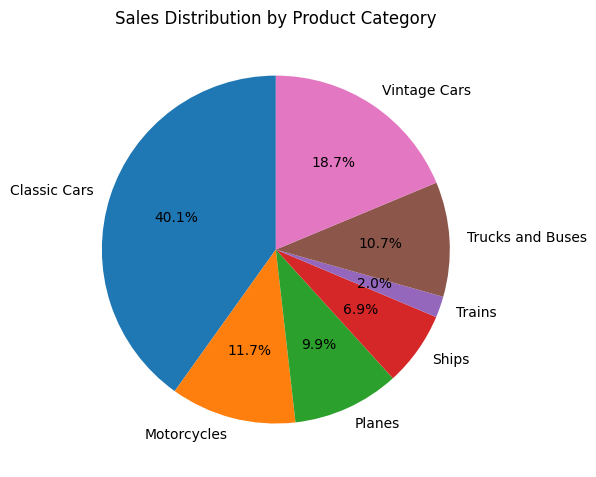

In [ ]:
#  Pie Chart of Sales by Product Category ===
# Purpose: Illustrate each productLine’s share of total order revenue.

# 1. Merge orderdetails ↔ products to get productLine
df_for_pie = (
    orderdetails
    .merge(
        products[['productCode','productLine']],   # only productLine is needed here
        on='productCode'
    )
    # 2. Compute line revenue using priceEach from orderdetails
    .assign(totalLine=lambda d: d['quantityOrdered'] * d['priceEach'])
)

# 3. Aggregate revenue by productLine
sales_by_line = df_for_pie.groupby('productLine')['totalLine'].sum()

# 4. Plot the pie chart
plt.figure(figsize=(6,6))
plt.pie(
    sales_by_line.values,
    labels=sales_by_line.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Sales Distribution by Product Category')
plt.tight_layout()
plt.show()


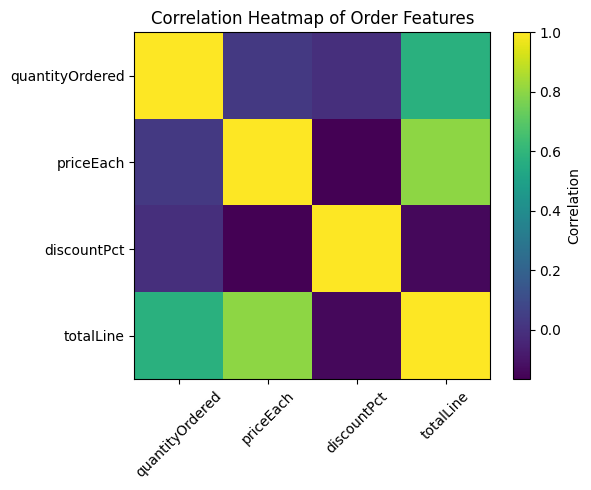

In [ ]:
# ===Correlation Heatmap of Numeric Features ===
# Purpose: Expose relationships between key numeric predictors and target.
numeric_cols = ['quantityOrdered', 'priceEach', 'discountPct', 'totalLine']
corr = df_ml[numeric_cols].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr, aspect='auto')
plt.colorbar(label='Correlation')
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title('Correlation Heatmap of Order Features')
plt.tight_layout()
plt.show()


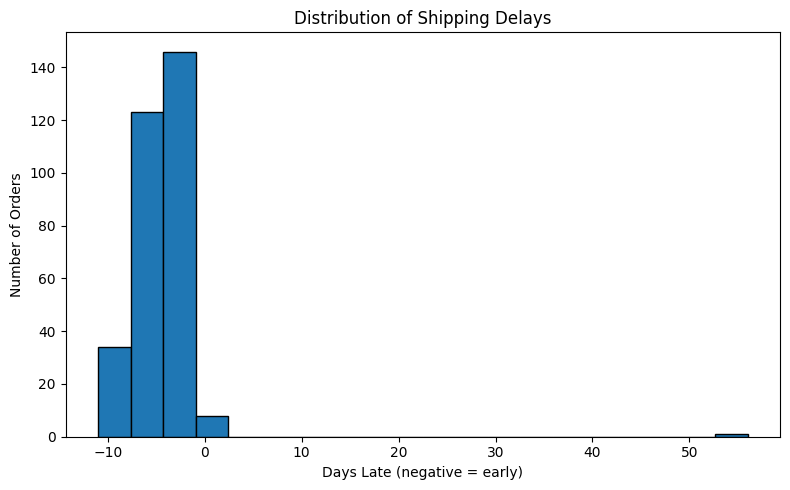

In [ ]:
# === Cell 12f: Histogram of Shipping Delays ===
# Purpose: Reveal distribution of on‑time vs. late shipments.
orders['shippedDate']  = pd.to_datetime(orders['shippedDate'])
orders['requiredDate'] = pd.to_datetime(orders['requiredDate'])
orders['ship_delay']   = (orders['shippedDate'] - orders['requiredDate']).dt.days

plt.figure(figsize=(8,5))
plt.hist(orders['ship_delay'].dropna(), bins=20, edgecolor='black')
plt.title('Distribution of Shipping Delays')
plt.xlabel('Days Late (negative = early)')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()